In [1]:
import sys
from matplotlib.figure import Figure
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import leastsq

import os
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier       
from sklearn.tree import DecisionTreeClassifier       
from sklearn.ensemble import RandomForestClassifier   
from sklearn.preprocessing import StandardScaler   
from scipy.stats import pearsonr                    
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split    
import seaborn as sns
sns.set()


# Data Preprocessing and Cleaning

In [2]:
data0=pd.read_csv('C:\\Users\\Jing\\Pulse Data\\Normal\\Night\\3.9Right Hand.csv',encoding='utf-8')
data0=data0.T
data0=data0.reset_index(level=0)
data0.columns=data0.iloc[0]
data0=data0.drop(0)
data0.head()

,CUN,GUAN,CHI
1,1556,1724,1144
2,1212,781,1053
3,1020,991,923
4,763,590,1415
5,1696,505,1342


In [3]:
cun11=data0['CUN'].tolist()
cun00=[eval(x) for x in cun11]  #Convert the STR data in 'CUN' to a computable data type using the eval () built-in method
 
#Remove NULL values and Blank Spaces 
NONE_VIN = (data0['GUAN'].isnull()) | (data0['GUAN'].apply(lambda x: str(x).isspace()))
guan11=data0['GUAN']
guan00 = guan11[~NONE_VIN].tolist()

NONE_VIN = (data0['CHI'].isnull()) | (data0['CHI'].apply(lambda x: str(x).isspace()))
chi11=data0['CHI']
chi00 = chi11[~NONE_VIN].tolist()

In [4]:
#Removal of baseline drift
def new_detrend(data):
    n=len(data)
    t=20
    if n<=t:
        return signal.detrend(data)
    result=[]
    p=0
    while n>t:
        for i in signal.detrend(data[p*t:(p+1)*t]):
            result.append(i)
        n-=t
        p+=1
    return result

#Returns the crest index
def getPeak(data):
    result=[]
    for n in range(6,len(data)):
        if data[n]>=max(data[n-4:n+5]):
            result.append(n)
    return result


### Removal of baseline drift

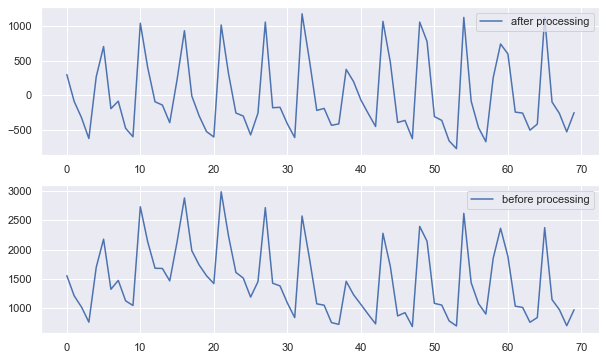

In [5]:
de_cun00=new_detrend(cun00)
de_guan00=new_detrend(guan00)
de_chi00=new_detrend(chi00)

n = 70  #  n: one fragment
begin = 0  # Start at 
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(range(n), de_cun00[begin:n + begin], label='after processing')
plt.legend(loc="upper right")
plt.subplot(2,1,2)
plt.plot(range(n), cun00[begin:n + begin], label='before processing')
plt.legend(loc="upper right")
plt.show()

### Periodic Superposition

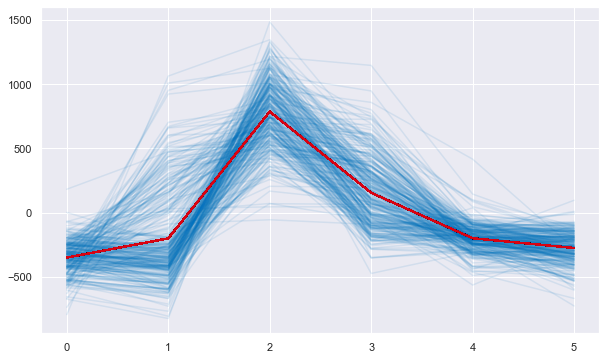

In [6]:
peak_cun00 = getPeak(de_cun00)
mean_cun00 = []
plt.figure(figsize=(10, 6))
for i in range(6):
            list_i00 = [de_cun00[t - 2 + i] for t in peak_cun00]
            sum00 = sum(list_i00)
            num00 = len(list_i00)
            mean_i00 = sum00 / num00
            mean_cun00.append(mean_i00)  # Mean Value
for t in peak_cun00:
    plt.plot(range(6), de_cun00[t - 2:t + 4], '#0073be', alpha=0.1)
    plt.plot(range(6), mean_cun00, '#da0312', alpha=1)

In [7]:
#Feature Extraction: f0, f1, f2, f3, f4, f5, f6, f7
def features(de_data):
    peak_data = getPeak(de_data)
    position = []  # Individual periods are extracted at positions 0,1,2,3,4 and 5, where 3 is the main peak position
    for i in range(6):
        list_i = [de_data[t - 2 + i] for t in peak_data[:-1]]
        position.append(list_i)
    f0 = sum(position[2]) / len(position[2])  
    f1 = np.std(position[2])
    f2 = f1 / np.mean(position[2])

    cb = []  # Repulse Wave
    jzx = []  # Dicrotic Notch
    for n in range(len(position[2])):
        if position[4][n] - position[3][n] > position[5][n] - position[4][n]:
            cb0 = position[4][n] - position[3][n]
            jzx0 = position[3][n]
        else:
            cb0 = position[5][n] - position[4][n]
            jzx0 = position[4][n]
        if cb0 > 0:
            cb.append(cb0)
            jzx.append(jzx0)
    f3 = np.mean(jzx)
    f4 = np.std(jzx)
    f5 = f4 / f3

    f6 = np.mean(cb)
    #f7 = sts.quantile(cb, p=0.75)
    f7 =np.quantile(cb, 0.75)
    return f0, f1, f2, f3, f4, f5, f6, f7, position[2], jzx, cb

# Load Dataset

In [8]:

path3 = 'C:\\Users\\Jing\\Pulse Data\\Hypertension Patients\\Morning\\'
path4 = 'C:\\Users\\Jing\\Pulse Data\\Hypertension Patients\\Night\\'
path5 = 'C:\\Users\\Jing\\Pulse Data\\Normal\\Morning\\'
path6 = 'C:\\Users\\Jing\\Pulse Data\\Normal\\Night\\'

path = [[path5, path6], [path3, path4]]

sample_list = []
sample_list2 = []
s_list = [sample_list, sample_list2]

for ite in range(2):
    csv_files = []  # All CSV files in the current directory
    for root, dirs, files in os.walk(path[ite][0]):  
        for i in files: 
            csv_files.append(root + i)  
    for root, dirs, files in os.walk(path[ite][1]):
        for i in files:
            csv_files.append(root + i)

    for csv_i in range(len(csv_files)): 


        data = pd.read_csv(csv_files[csv_i], encoding='gbk')

        data = data.T
        data = data.reset_index(level=0)
        data.columns = data.iloc[0]
        data = data.drop(0)

        NONE_VIN = (data['CUN'].isnull()) | (data['CUN'].apply(lambda x: str(x).isspace()))
        cun1 = data['CUN']
        cun2 = cun1[~NONE_VIN].tolist()
        cun = []
        for i in cun2:
            if i[0] != 'U':
                cun.append(eval(i))
            else:
                break

        NONE_VIN = (data['GUAN'].isnull()) | (data['GUAN'].apply(lambda x: str(x).isspace()))
        guan1 = data['GUAN']
        guan = guan1[~NONE_VIN].tolist()

        NONE_VIN = (data['CHI'].isnull()) | (data['CHI'].apply(lambda x: str(x).isspace()))
        chi1 = data['CHI']
        chi = chi1[~NONE_VIN].tolist()

        de_cun = new_detrend(cun)

        de_guan = new_detrend(guan)

        de_chi = new_detrend(chi)

    
        peak_cun = getPeak(de_cun)
        mean_cun = []
        for i in range(6):
            list_i = [de_cun[t - 2 + i] for t in peak_cun[:-1]]
            sum0 = sum(list_i)
            num0 = len(list_i)
            mean_i = sum0 / num0
            mean_cun.append(mean_i)
        fff1 = features(de_cun)

 
        peak_guan = getPeak(de_guan)
        mean_guan = []
        for i in range(6):
            list_i = [de_guan[t - 2 + i] for t in peak_guan[:-1]]
            sum0 = sum(list_i)
            num0 = len(list_i)
            mean_i = sum0 / num0
            mean_guan.append(mean_i)
        fff2 = features(de_guan)

     
        peak_chi = getPeak(de_chi)
        mean_chi = []
        for i in range(6):
            list_i = [de_chi[t - 2 + i] for t in peak_chi[:-1]]
            sum0 = sum(list_i)
            num0 = len(list_i)
            mean_i = sum0 / num0
            mean_chi.append(mean_i)
        fff3 = features(de_chi)



        data = [de_cun, de_guan, de_chi, mean_cun, mean_guan, mean_chi]

        fea1_value = [p for p in fff1[:-3]]
        fea2_value = [p for p in fff2[:-3]]
        fea3_value = [p for p in fff3[:-3]]
        sample = []
        for i in fea1_value:
            sample.append(i)
        for i in fea2_value:
            sample.append(i)
        for i in fea3_value:
            sample.append(i)
        s_list[ite].append(sample)

X=[]
Y=[]
for i in sample_list:
    X.append(i)
    Y.append(0)
for i in sample_list2:
    X.append(i)
    Y.append(1)

val_name=['CUN Main Wave Height Mean','CUN Main Wave Standard Deviation','CUN Main wave Dispersion Coefficient',
          'CUN Dicrotic Notch Height Mean','CUN Dicrotic Notch Standard Deviation','CUN Dicrotic Notch Dispersion Coefficient',
          'CUN Repulse Wave Height Mean', 'CUN Repulse Wave75% quantile',
          'GUAN Main Wave Height Mean','GUAN Main Wave Standard Deviation','GUAN Main wave Dispersion Coefficient',
          'GUAN Dicrotic Notch Height Mean','GUAN Dicrotic Notch Standard Deviation','GUAN Dicrotic Notch Dispersion Coefficient',
          'GUAN Repulse Wave Height Mean', 'GUAN Repulse Wave75% quantile',
          'CHI Main Wave Height Mean','CHI Main Wave Standard Deviation','CHI Main wave Dispersion Coefficient',
          'CHI Dicrotic Notch Height Mean','CHI Dicrotic Notch Standard Deviation','CHI Dicrotic Notch Dispersion Coefficient',
          'CHI Repulse Wave Height Mean', 'CHI Repulse Wave75% quantile']

data_dic={}
for i in range(len(val_name)):
    data_dic[val_name[i]]=[m[i] for m in X]
df=pd.DataFrame(data_dic)
df['label']=Y


In [9]:
df.head()

,CUN Main Wave Height Mean,CUN Main Wave Standard Deviation,CUN Main wave Dispersion Coefficient,CUN Dicrotic Notch Height Mean,CUN Dicrotic Notch Standard Deviation,CUN Dicrotic Notch Dispersion Coefficient,CUN Repulse Wave Height Mean,CUN Repulse Wave75% quantile,GUAN Main Wave Height Mean,GUAN Main Wave Standard Deviation,...,GUAN Repulse Wave75% quantile,CHI Main Wave Height Mean,CHI Main Wave Standard Deviation,CHI Main wave Dispersion Coefficient,CHI Dicrotic Notch Height Mean,CHI Dicrotic Notch Standard Deviation,CHI Dicrotic Notch Dispersion Coefficient,CHI Repulse Wave Height Mean,CHI Repulse Wave75% quantile,label
0,421.203167,116.880374,0.277492,-435.382104,192.887381,-0.443030,338.313981,429.289380,291.217628,125.910431,...,314.468045,365.302953,78.730096,0.215520,-50.077277,101.792611,-2.032711,67.200585,73.149248,0
1,770.192502,148.662193,0.193020,-83.744209,112.658731,-1.345272,79.016269,113.574004,560.162008,157.355227,...,73.699248,294.148916,69.544149,0.236425,-24.188951,47.815350,-1.976743,38.194994,52.742857,0
2,944.161055,234.335098,0.248194,-19.157127,170.921548,-8.922087,134.858950,201.507744,238.509654,91.790120,...,201.817669,461.346717,108.792005,0.235814,-86.777495,137.368188,-1.582993,144.205341,223.346617,0
3,856.558494,230.216805,0.268770,-128.474943,99.304050,-0.772945,86.452608,116.504586,870.856837,215.130052,...,151.958835,206.585898,69.907093,0.338392,-6.644786,52.114906,-7.842977,35.651801,44.953008,0
4,846.786262,307.172779,0.362751,-207.031080,143.607875,-0.693654,131.264660,191.591128,894.930175,216.270356,...,139.431579,441.889555,122.802662,0.277904,-37.127390,135.240263,-3.642601,108.492911,176.072556,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CUN Main Wave Height Mean                   55 non-null     float64
 1   CUN Main Wave Standard Deviation            55 non-null     float64
 2   CUN Main wave Dispersion Coefficient        55 non-null     float64
 3   CUN Dicrotic Notch Height Mean              55 non-null     float64
 4   CUN Dicrotic Notch Standard Deviation       55 non-null     float64
 5   CUN Dicrotic Notch Dispersion Coefficient   55 non-null     float64
 6   CUN Repulse Wave Height Mean                55 non-null     float64
 7   CUN Repulse Wave75% quantile                55 non-null     float64
 8   GUAN Main Wave Height Mean                  55 non-null     float64
 9   GUAN Main Wave Standard Deviation           55 non-null     float64
 10  GUAN Main wave D

In [11]:
df.isnull().sum()

CUN Main Wave Height Mean                     0
CUN Main Wave Standard Deviation              0
CUN Main wave Dispersion Coefficient          0
CUN Dicrotic Notch Height Mean                0
CUN Dicrotic Notch Standard Deviation         0
CUN Dicrotic Notch Dispersion Coefficient     0
CUN Repulse Wave Height Mean                  0
CUN Repulse Wave75% quantile                  0
GUAN Main Wave Height Mean                    0
GUAN Main Wave Standard Deviation             0
GUAN Main wave Dispersion Coefficient         0
GUAN Dicrotic Notch Height Mean               0
GUAN Dicrotic Notch Standard Deviation        0
GUAN Dicrotic Notch Dispersion Coefficient    0
GUAN Repulse Wave Height Mean                 0
GUAN Repulse Wave75% quantile                 0
CHI Main Wave Height Mean                     0
CHI Main Wave Standard Deviation              0
CHI Main wave Dispersion Coefficient          0
CHI Dicrotic Notch Height Mean                0
CHI Dicrotic Notch Standard Deviation   

# Visualizing  Distributions

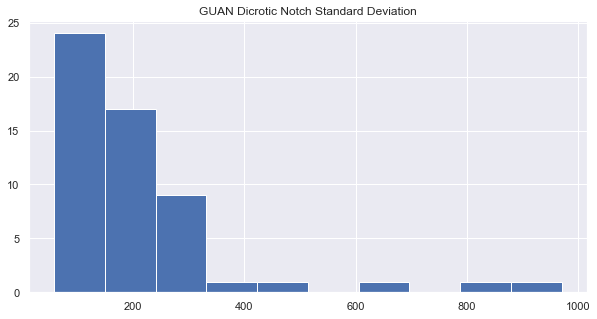

In [12]:
plt.figure(figsize=(10,5))
plt.hist(df['GUAN Dicrotic Notch Standard Deviation'],bins=10)
plt.title("GUAN Dicrotic Notch Standard Deviation")
plt.show()

According to the histogram above, it is shown that the majority of pulse data is mainly concentrated between 100 and 300. 

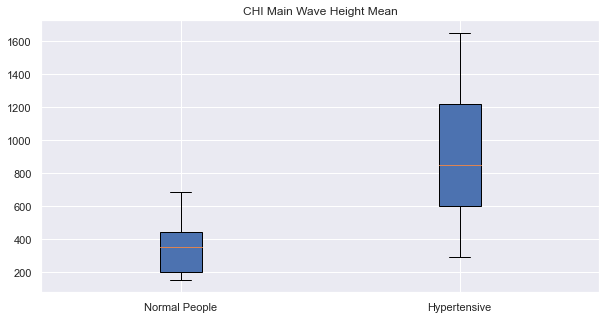

In [13]:
box_1,box_2 = df.loc[df['label']== 0]['CHI Main Wave Height Mean'],df.loc[df['label']== 1]['CHI Main Wave Height Mean']
box_11=box_1.tolist()      #Normal People
box_22=box_2.tolist()      #Hypertensive
normal_label = df[:28]['label'].tolist()
hypertensive_label = df[28:55]['label'].tolist()

plt.figure(figsize=(10,5))
labels = 'Normal People','Hypertensive'
plt.boxplot([box_11,box_22],labels =labels,patch_artist = True)
plt.title("CHI Main Wave Height Mean")
plt.show()

According to the visualized data distribution boxplot above,
the pulse data of hypertensive patients is significantly higher than that of normal people

# Feature Engineering

In [14]:
mb_data = df.iloc[:,:-1]
mb_target = df['label']
mb_data_train,mb_data_test,mb_target_train,mb_target_test = train_test_split(mb_data,mb_target,test_size=0.2,random_state=42)

stdScaler=StandardScaler().fit(mb_data_train)         #Instantiation，data is converted to a normal distribution between 0 and 1
mb_trainStd=stdScaler.transform(mb_data_train)        #  mean and Variance
mb_testStd=stdScaler.transform(mb_data_test)

### Standardization：the mean of the attribute becomes zero and distribution has a unit standard deviation

In [15]:
int(mb_testStd.mean())

0

In [16]:
int(mb_testStd.std())

1

### Feature Importance


 24 Important features(> 0 % of max importance)...



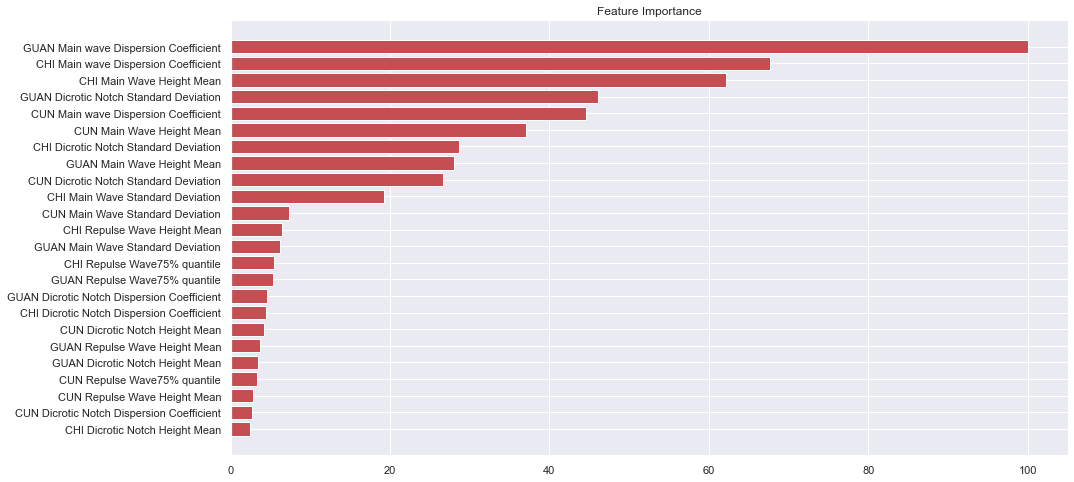

In [17]:
features_list = df.iloc[:, :-1].columns
forest = RandomForestClassifier(oob_score=True, n_estimators=10000)  
forest.fit(df.iloc[:, :-1], Y)  
feature_importance = forest.feature_importances_  # feature_importances_ 
feature_importance = 100.0 * (feature_importance / feature_importance.max())
fi_threshold = 0
important_idx = np.where(feature_importance > fi_threshold)[0]
important_features = features_list[important_idx]
print("\n", important_features.shape[0], "Important features(>", \
        fi_threshold, "% of max importance)...\n")
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]  

pos = np.arange(sorted_idx.shape[0]) + .5  

plt.figure(figsize=(15,8))
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]],tick_label=important_features[sorted_idx[::-1]],color='r', align='center')
plt.title("Feature Importance")
plt.show()

# Model Training

(79.02640687567316, 1722.6790862461635)

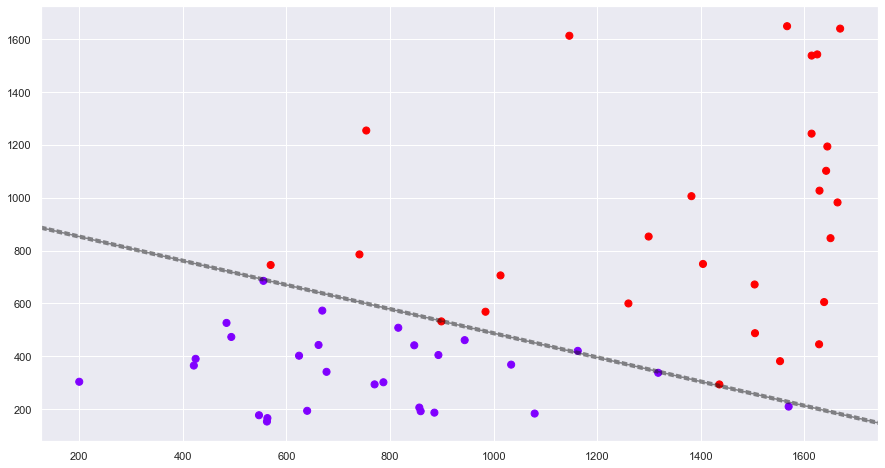

In [18]:
JJ_Test=df.iloc[:,[0,16]]  
fig = plt.figure(figsize=(15,8))
plt.scatter(JJ_Test.values[:, 0], JJ_Test.values[:, 1],c=Y, s=50, cmap="rainbow")
ax = plt.gca() 
xlim = ax.get_xlim()
ylim = ax.get_ylim()
axisx = np.linspace(xlim[0], xlim[1], 30)
axisy = np.linspace(ylim[0], ylim[1], 30)  
axisx, axisy = np.meshgrid(axisx, axisy) 
xy = np.vstack([axisx.ravel(), axisy.ravel()]).T 

clf = SVC(kernel='linear').fit(JJ_Test, Y)
Z = clf.decision_function(xy).reshape(axisx.shape)  #decision_functioon，Returns the distance from the decision boundary for each input sample
#HINT: contour():requires that the structure of Z must be consistent with X and Y
ax.contour(axisx, axisy, Z  
                   , colors='k'
                   , levels=[-1, 0, 1]  
                   , alpha=0.5  
                   , linestyles=["--", "-", "--"])

ax.set_xlim(xlim)
ax.set_ylim(ylim)